In [1]:
# Libraries needed 
import h5py
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.spatial.distance import cdist


In [2]:
# upload data 
hdf5data_109 = h5py.File('../../Data/data_109.h5', 'r')
hdf5data_130 = h5py.File('../../Data/data_130.h5', 'r')
hdf5data_142 = h5py.File('../../Data/data_142.h5', 'r')
hdf5data_143 = h5py.File('../../Data/data_143.h5', 'r')

## Transferring detections into a dataframe 

In [3]:
def fill_rows_detections(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf

In [4]:
def df_detections(h5data,camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        detection = np.asarray(d['Detections'])
        
        if detection.size:
            append_df = fill_rows_detections(detection, append_df)
            append_df['timestamp'] = t
            append_df['frame'] = c
        
            if camera is not None:
                append_df['camera'] = camera
        
            df = df.append(append_df)
    
    return df

In [5]:
df_109 = df_detections(hdf5data_109, 109)
df_109.reset_index(inplace=True, drop=True)
df_130 = df_detections(hdf5data_130, 130)
df_130.reset_index(inplace=True, drop=True)
df_142 = df_detections(hdf5data_142, 142)
df_142.reset_index(inplace=True, drop=True)
df_143 = df_detections(hdf5data_143, 143)
df_143.reset_index(inplace=True, drop=True)

In [11]:
df_to_concat = [df_109,df_130,df_142,df_143]
df_complete = pd.concat(df_to_concat)
df_complete.sort_values(by = ['frame'], inplace = True)
df_complete.reset_index(inplace=True, drop=True)
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,10.591985,-33.300211,-1.254730,3.106008,2.026976,2.356834,1.390347,1.574333e+09,0,143
2,2.417817,-32.064833,-0.609711,0.641007,0.489730,0.741013,-0.615712,1.574333e+09,0,143
3,13.233552,-5.117304,-0.707404,9.933850,2.673657,1.161759,1.067465,1.574333e+09,0,143
4,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,1.574333e+09,0,130
...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109
11741,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142
11743,9.499622,-1.782256,-1.109378,4.979414,2.787621,1.340728,1.181705,1.574333e+09,749,109


## Frame visualization

In [16]:
def convert_to_image_space ( coordinates , world2cam , cam2im ):
    """ Input single set of coordinatetes """
    coord_4 = np.ones (4)
    coord_4[0:3] = coordinates
    cams_coord = ( np.matmul( world2cam , coord_4.T )).T
    cams_coord_4 = np.ones(4)
    
    cams_coord_4 [0:3] = cams_coord [0:3]
    ims_coord = ( np . matmul ( cam2im , cams_coord_4 .T )). T
    # Divide by z coordinate for some reason
    ims_coord [0] = ims_coord [0]/ ims_coord [2]
    ims_coord [1] = ims_coord [1]/ ims_coord [2]
    ims_coord = ims_coord [0:2]
    
    return ( ims_coord )


def visualize_frame_detections ( camera, frame_idx, figsize = None , s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])

    x_list = []
    y_list = []

    for point in detected_points:
    
        world_pos = np.array(point[0].tolist())
        fin_pos = convert_to_image_space(world_pos, camera['TMatrixWorldToCam'], camera['ProjectionMatrix'])
        x_list.append(fin_pos[0])
        y_list.append(fin_pos[1])

    # Show image
    a = np.asarray(frame['Image'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    plt.imshow(a, cmap = 'gist_gray', zorder = 1)
    plt.scatter(x_list, y_list, s = s, color = 'hotpink', zorder = 3)
    
    return

def visualize_frame_boxes ( camera, frame_idx, figsize = None, s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    
    for point in detected_points:
        # first face 
        unrotated_vertex1 = np.array([+ point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex2 = np.array([+ point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex3 = np.array([+ point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex4 = np.array([+ point['Length']/2, - point['Width']/2, + point['Height']/2])
        # second face 
        unrotated_vertex5 = np.array([- point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex6 = np.array([- point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex7 = np.array([- point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex8 = np.array([- point['Length']/2, - point['Width']/2, + point['Height']/2])
        
        
        unrotated_vertex_list = [unrotated_vertex1, unrotated_vertex2, unrotated_vertex3, 
                                 unrotated_vertex4, unrotated_vertex5, unrotated_vertex6, 
                                 unrotated_vertex7, unrotated_vertex8]
        
        rotation_matrix = np.array([[np.cos(point['Angle']), -np.sin(point['Angle']), 0], 
                            [np.sin(point['Angle']), np.cos(point['Angle']), 0], 
                            [0,0,1]])
        
        rotated_vertex_list = np.array([rotation_matrix.dot(v) for v in unrotated_vertex_list])
        rotated_vertex_list = rotated_vertex_list + np.array([point['Pos']['X'], point['Pos']['Y'], point['Pos']['Z']])
        
        vertex_im_list = [convert_to_image_space(v, camera['TMatrixWorldToCam'], camera['ProjectionMatrix']) for v in rotated_vertex_list]
        
        
        combinations = [(i,i+1) for i in range(3)] + [(3,0)] + [(i,i+1) for i in range(4,7)] + [
            (7,4)] + [(i,i+4) for i in range(4)]
        
        for (i,j) in combinations: 
            vertex_x_list = [vertex_im_list[i][0],vertex_im_list[j][0]]
            vertex_y_list = [vertex_im_list[i][1],vertex_im_list[j][1]]
            plt.plot(vertex_x_list, vertex_y_list, color = 'b', zorder = 2)
        
        
        
    visualize_frame_detections ( camera, frame_idx, s = s )
    
    return

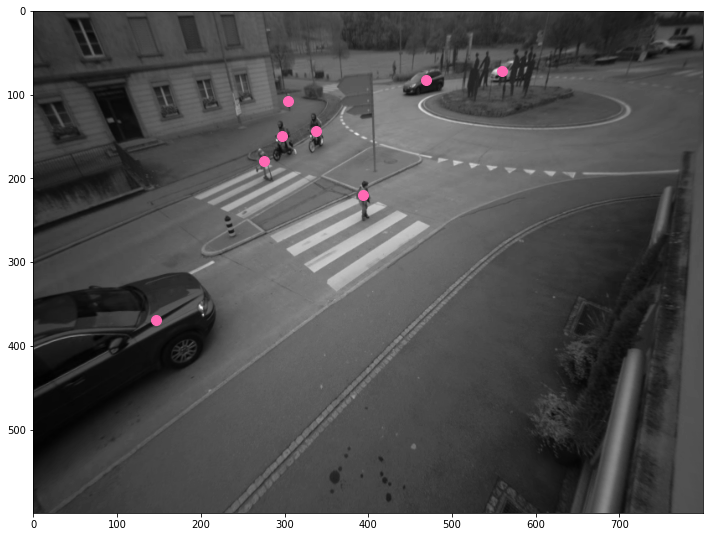

In [27]:
visualize_frame_detections(hdf5data_109,260, figsize = (12,12))

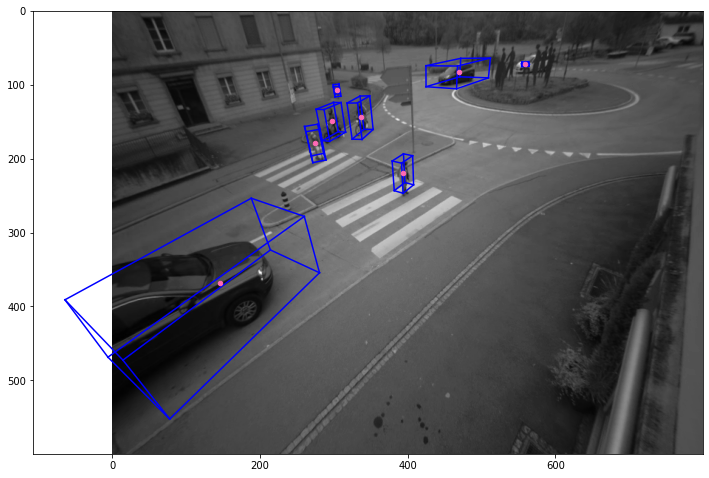

In [28]:
visualize_frame_boxes(hdf5data_109, 260, figsize = (12,12), s = 20)

## Use Df


In [12]:
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,10.591985,-33.300211,-1.254730,3.106008,2.026976,2.356834,1.390347,1.574333e+09,0,143
2,2.417817,-32.064833,-0.609711,0.641007,0.489730,0.741013,-0.615712,1.574333e+09,0,143
3,13.233552,-5.117304,-0.707404,9.933850,2.673657,1.161759,1.067465,1.574333e+09,0,143
4,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,1.574333e+09,0,130
...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109
11741,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142
11743,9.499622,-1.782256,-1.109378,4.979414,2.787621,1.340728,1.181705,1.574333e+09,749,109


In [13]:
df_complete[df_complete['frame'] == 0]

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,10.591985,-33.300211,-1.254730,3.106008,2.026976,2.356834,1.390347,1.574333e+09,0,143
2,2.417817,-32.064833,-0.609711,0.641007,0.489730,0.741013,-0.615712,1.574333e+09,0,143
3,13.233552,-5.117304,-0.707404,9.933850,2.673657,1.161759,1.067465,1.574333e+09,0,143
4,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,1.574333e+09,0,130
5,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130
6,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109
7,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109
8,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109


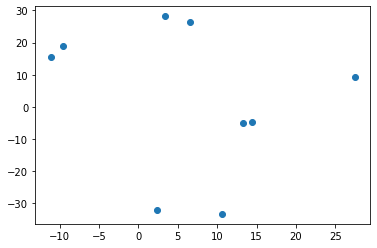

In [14]:
x = df_complete['X_box'][df_complete['frame'] == 0]
y = df_complete['Y_box'][df_complete['frame'] == 0]

plt.scatter(x,y)

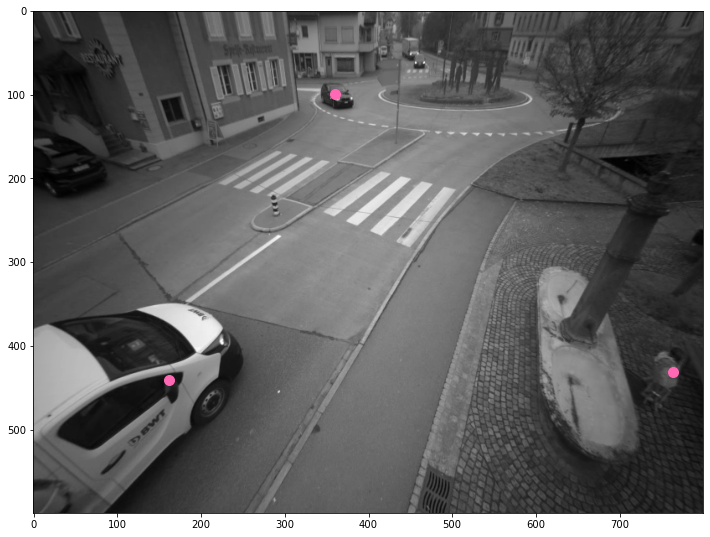

In [21]:
visualize_frame_detections(hdf5data_143, 0, figsize = (12,12))

In [77]:
# Obj = { 'x' : 1, 'y': 1, 'z': 1, 'l': 10, 'w': 10, 'h' : 10, 'angle' : np.pi/2}

deltaT = 0.08
threshold = 5

class Track:
    
    def __init__(self, ID, OBJ, FRAME, threshold = threshold):
        self.ID = ID
        self.status = 'New'  #New, Pending, Active, Inactive
        self.objects = [OBJ]
        self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
        self.frames = [FRAME]
        self.velocity = []
        self.type = None
        self.threshold = threshold
        self.filter = None
        global track_id
        track_id = ID + 1
    
    def update_track(self, OBJ, FRAME):
        self.objects.append(OBJ)
        self.frames.append(FRAME)
        self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z #We should use KF.filter
        self.status = 'Active'
    
    def set_status(self, status):
        self.status = status
    
    def compute_vel ( self, OBJ ): #TO DO WITH KALMAN FILTERS NOT THIS SH*T
        vx = (OBJ['x'] - self.objects[-1]['x'])/deltaT
        vy = (OBJ['y'] - self.objects[-1]['y'])/deltaT
        vz = (OBJ['z'] - self.objects[-1]['z'])/deltaT
        
        self.velocity.append((vx,vy, vz))
        
        return
    
    def set_type( self, TYPE ):
        self.type = TYPE
        set_threshold()
        return
    
    def set_threshold (self):
        
        if type == 'car':
            self.threshold = 3
        
        else:
            self.threshold = 10
            
        return

class Object:
    def __init__(self, x, y, z, l, w, h, angle):
        self.x = x
        self.y = y
        self.z = z
        self.length = l
        self.width = w
        self.height = h
        self.angle = angle


In [92]:
track_id = 0
frame_index = 0
frame = df_complete[df_complete['frame'] == frame_index]

display(frame)

### Setup at frame 0
obj_list = []
tracks = {'active': [], 'pending': [], 'inactive': [], 'new': []}
for index, row in frame.iterrows():
    obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], row['width_box'], row['height_box'], row['angle_box'])
    obj_list.append(obj)
    tr = Track(track_id, obj, frame_index)
    tracks['new'].append(tr)


### New Frame
frame_index = 1
frame = df_complete[df_complete['frame'] == frame_index]
frame.reset_index(inplace=True, drop=True)
display(frame)
obj_list = []

### Retrieve objects
for index, row in frame.iterrows():
    obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], row['width_box'], row['height_box'], row['angle_box'])
    obj_list.append(obj)

obj_list = np.array(obj_list)

### Associate 
obj_coord = [[obj.x, obj.y, obj.z] for obj in obj_list]

# At first we use Active Tracks
track_act_coord = np.array([[t.x, t.y, t.z] for t in tracks['active']]) #We should use KF.predict here and not consider only the new set

if track_act_coord.size:
    dists = cdist(track_act_coord, obj_coord, 'euclidean') 
    #Using Nearest Neighbour -> not right, will always connect a track to an object
    associations = np.argmin(dists, axis=1)
    print(associations)

    for index, ass in enumerate(associations):
        tracks['active'][index].update_track(obj_list[ass], frame_index)

    obj_list = np.delete(obj_list, associations)

track_new_coord = np.array([[t.x, t.y, t.z] for t in tracks['new']]) #We should use KF.predict here and not consider only the new set

if track_new_coord.size:
    dists = cdist(track_new_coord, obj_coord, 'euclidean') 
    #Using Nearest Neighbour -> not right, will always connect a track to an object
    associations = np.argmin(dists, axis=1)
    print(associations)

    for index, ass in enumerate(associations):
        tracks['new'][index].update_track(obj_list[ass], frame_index)

    obj_list = np.delete(obj_list, associations)

for tr in tracks['new'][::-1]:
    if tr.status == 'Active':
        tracks['new'].remove(tr)
        tracks['active'].append(tr)
        
print(tracks)
for obj in obj_list:
    tr = Track(track_id, obj, frame_index)
    tracks['new'].append(tr)

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,10.591985,-33.300211,-1.254730,3.106008,2.026976,2.356834,1.390347,1.574333e+09,0,143
2,2.417817,-32.064833,-0.609711,0.641007,0.489730,0.741013,-0.615712,1.574333e+09,0,143
3,13.233552,-5.117304,-0.707404,9.933850,2.673657,1.161759,1.067465,1.574333e+09,0,143
4,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,1.574333e+09,0,130
5,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130
6,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109
7,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109
8,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109


,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-9.487168,19.018149,-1.403667,2.751621,1.204600,1.533254,-0.508305,1.574333e+09,1,109
1,-11.137152,15.415920,-0.911968,1.352618,0.546684,1.370234,0.708852,1.574333e+09,1,109
2,13.044299,-5.497306,-0.693706,10.872630,3.128635,0.948253,1.164406,1.574333e+09,1,143
3,2.427649,-32.079108,-0.605736,0.617645,0.512637,0.735474,-0.749255,1.574333e+09,1,143
4,10.460591,-32.968130,-1.340568,3.902771,2.242807,2.530253,-1.561048,1.574333e+09,1,143
5,10.193464,-3.254121,-0.711990,1.412921,0.266124,0.460025,1.337511,1.574333e+09,1,109
6,-8.244665,-16.619673,-2.642268,5.584267,0.324819,0.769942,-0.745784,1.574333e+09,1,142
7,27.366480,9.388028,-0.620996,2.423051,0.704623,1.189200,-0.820607,1.574333e+09,1,130
8,14.292184,-4.719566,-1.036344,3.694674,2.879994,1.621184,0.862217,1.574333e+09,1,130
9,6.557454,26.324931,-0.863639,1.568051,0.584425,1.166256,0.442498,1.574333e+09,1,109


[ 1  4  3  2  7  8  9 10  0]
{'active': [<__main__.Track object at 0x0000018F75B79DC0>, <__main__.Track object at 0x0000018F75B795B0>, <__main__.Track object at 0x0000018F745F0550>, <__main__.Track object at 0x0000018F75B79550>, <__main__.Track object at 0x0000018F75B79970>, <__main__.Track object at 0x0000018F76416970>, <__main__.Track object at 0x0000018F77328CD0>, <__main__.Track object at 0x0000018F776ED700>, <__main__.Track object at 0x0000018F77328DF0>], 'pending': [], 'inactive': [], 'new': []}


In [93]:
tracks

{'active': [<__main__.Track at 0x18f75b79dc0>,
 'pending': [],
 'inactive': [],
 'new': [<__main__.Track at 0x18f76a58580>, <__main__.Track at 0x18f775749d0>]}